<a href="https://colab.research.google.com/github/nehahimane/COMP_6721_Project_GroupS/blob/AI_Hardik/VGG19_Fer_Custom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/dataset"

In [ ]:
%cd /content/drive/MyDrive/AI_Datasets

/content/drive/MyDrive/AI_Datasets


In [ ]:
!kaggle datasets download -d nightfury007/fercustomdataset-3classes

100% 83.0M/83.1M [00:00<00:00, 159MB/s]
100% 83.1M/83.1M [00:00<00:00, 142MB/s]


In [ ]:
import zipfile
for file in os.listdir():
    if file.endswith(".zip"):
        with zipfile.ZipFile(file, "r") as zip_file:
            zip_file.extractall()
        os.remove(file)

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hardikamareliya1","key":"0268c8e1e818b3cba6317fe09919c34a"}'}

In [3]:
!mkdir ~/.kaggle

In [4]:
!cp kaggle.json ~/.kaggle/

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets list

ref                                                             title                                            size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  ----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
akshaydattatraykhare/diabetes-dataset                           Diabetes Dataset                                  9KB  2022-10-06 08:55:25          12342        391  1.0              
whenamancodes/covid-19-coronavirus-pandemic-dataset             COVID -19 Coronavirus Pandemic Dataset           11KB  2022-09-30 04:05:11           9863        302  1.0              
stetsondone/video-game-sales-by-genre                           Video Game Sales by Genre                        12KB  2022-10-31 17:56:01           1105         28  1.0              
whenamancodes/credit-card-customers-prediction                  Credit Card Cust

In [7]:
!kaggle datasets download -d nightfury007/fercustomdataset-3classes

 97% 81.0M/83.1M [00:04<00:00, 22.6MB/s]
100% 83.1M/83.1M [00:04<00:00, 18.2MB/s]


In [8]:
!mkdir dataset

In [26]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
import glob
import torch.optim as optim
import time
import cv2
import torchvision.datasets as datasets
from tqdm import tqdm
%matplotlib inline

In [12]:
data_dir = '/content/dataset/FER_Custom_Dataset'
IMAGE_DIM=224

print(os.listdir(data_dir))

['Disappointed', 'interested', 'neutral']


In [20]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [35]:
transform_dict ={'src': transforms.Compose([transforms.Grayscale(num_output_channels=3),
                                                transforms.Resize(IMAGE_DIM),
                                                transforms.ToTensor(),
                                                
                                               ]
                                              )
                    }
dataset = datasets.ImageFolder(data_dir, transform=transform_dict.get('src'))
full_loader = torch.utils.data.DataLoader(dataset, shuffle=False, num_workers=os.cpu_count())
print(len(full_loader))
N_CHANNELS = 1


mean = torch.zeros(1)
std = torch.zeros(1)
print('==> Computing mean and std..')
for inputs, _labels in tqdm(full_loader):
    for i in range(N_CHANNELS):
        mean[i] += inputs[:,i,:,:].mean()
        std[i] += inputs[:,i,:,:].std()
mean.div_(len(dataset))
std.div_(len(dataset))
print(mean, std)

43819
==> Computing mean and std..


100%|██████████| 43819/43819 [02:20<00:00, 311.25it/s]


tensor([0.4940]) tensor([0.2021])


In [36]:
def load_data(path, test_split, batch_size, input_size, shuffle_dataset=True,random_seed=42):

    transform_dict ={'src': transforms.Compose([transforms.Grayscale(num_output_channels=3),
                                                transforms.Resize(IMAGE_DIM),
                                                transforms.ToTensor(),
                                                transforms.Normalize(mean=[0.494,0.494, 0.494],
                                                                     std=[0.2021, 0.202, 0.202]
                                                                    )
                                               ]
                                              )
                    }
    
    dataset = datasets.ImageFolder(data_dir, transform=transform_dict.get('src'))
    dataset_size = len(dataset)
    train_test_indices = list(range(dataset_size))
    test_split = int(np.floor(test_split * dataset_size))
    
    if shuffle_dataset :
        np.random.seed(random_seed)
        np.random.shuffle(train_test_indices)
    train_indices, test_indices = train_test_indices[test_split:], train_test_indices[:test_split]
    

    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    test_sampler = SubsetRandomSampler(test_indices)

    data_loader_train = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                              sampler=train_sampler)
    data_loader_test = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                    sampler=test_sampler)
    
    return data_loader_train, data_loader_test

In [37]:
train_loader, test_loader=load_data(data_dir,0.2,32,(64,64))

print(len(train_loader), len(test_loader))

1096 274


In [38]:
######## Write your code here ##############
model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg19', pretrained=False)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [39]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))
model.to(device)

num_epochs = 10
total_steps = len(train_loader)
t1 = time.time()
training_loss = []
training_accuracy = []
for epoch in range(num_epochs):
    temp_loss = []
    temp_accu = []
    for i, data in enumerate(train_loader):
        images, labels = data[0].to(device), data[1].to(device)
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backprop and optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Train accuracy
        total = labels.size(0)
        _,predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                .format(epoch + 1, num_epochs, i + 1, total_steps, loss.item(),
                    (correct / total) * 100))
            temp_loss.append(loss.item())
            temp_accu.append((correct / total) * 100)
    print(f'Loss After {epoch+1} epoch : ', sum(temp_loss)/len(temp_loss))
    print(f'Accuracy After {epoch+1} epoch : ', sum(temp_accu)/len(temp_accu))
    training_loss.append(sum(temp_loss)/len(temp_loss))
    training_accuracy.append(sum(temp_accu)/len(temp_accu))
print("######## Training Finished in {} seconds ###########".format(time.time()-t1))

Device: cuda:0
Epoch [1/10], Step [100/1096], Loss: 1.1680, Accuracy: 21.88%
Epoch [1/10], Step [200/1096], Loss: 1.1394, Accuracy: 34.38%
Epoch [1/10], Step [300/1096], Loss: 1.0930, Accuracy: 37.50%
Epoch [1/10], Step [400/1096], Loss: 1.1090, Accuracy: 28.12%
Epoch [1/10], Step [500/1096], Loss: 1.1152, Accuracy: 31.25%
Epoch [1/10], Step [600/1096], Loss: 1.0392, Accuracy: 53.12%
Epoch [1/10], Step [700/1096], Loss: 1.1265, Accuracy: 25.00%
Epoch [1/10], Step [800/1096], Loss: 1.0459, Accuracy: 50.00%
Epoch [1/10], Step [900/1096], Loss: 1.0526, Accuracy: 46.88%
Epoch [1/10], Step [1000/1096], Loss: 1.0877, Accuracy: 43.75%
Loss After 1 epoch :  1.097654151916504
Accuracy After 1 epoch :  37.1875
Epoch [2/10], Step [100/1096], Loss: 1.0539, Accuracy: 43.75%
Epoch [2/10], Step [200/1096], Loss: 1.0701, Accuracy: 46.88%
Epoch [2/10], Step [300/1096], Loss: 1.1078, Accuracy: 37.50%
Epoch [2/10], Step [400/1096], Loss: 1.1042, Accuracy: 34.38%
Epoch [2/10], Step [500/1096], Loss: 1.058

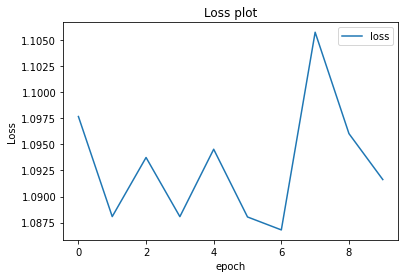

In [40]:
epochs = [i for i in range(num_epochs)]
plt.figure()
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Loss plot')

plt.plot(epochs,training_loss,label='loss')    
plt.legend()

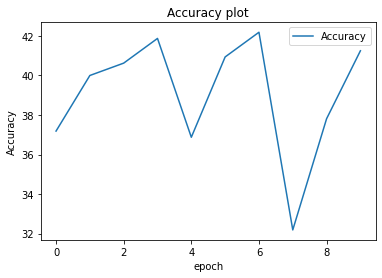

In [42]:
epochs = [i for i in range(num_epochs)]
plt.figure()
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy plot')

plt.plot(epochs,training_accuracy,label='Accuracy')    
plt.legend()